# Multi-label Prediction with Planet Amazon Dataset Using Fastai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

Once the essential library(ies) have been loaded, we will proceed to download the dataset using the Kaggle API.

Just to refresh my memory, the following command installs the Kaggle API on a local machine.

In [3]:
# !{sys.executable} -m pip install kaggle --upgrade

We will then head on over to Kaggle's "My Account" section to create a new API token for ourselves. The resulting "kaggle.json" file will need to be uploaded on the main Jupyter page, inside the directory of this, or any related, notebook.

Then, we wrap up the permissions section with the following code:

In [5]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [ ]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

Since the dataset has already been downloaded and extracted, we just need to create a path to point to it's location on our local machine.

In [3]:
PATH = '/home/bilal/.fastai/data/planet/'

## Multi-label Classification

### Prepping DataBunch

We will use fastai's excellent DataBlock API to put our data in a DataBunch. But first, lets take a look at the 'train_v2.csv' file to get an idea of the image labels we will be dealing with.a

In [4]:
df = pd.read_csv(f'{PATH}train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
df.tail()

,image_name,tags
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road
40478,train_40478,agriculture cultivation partly_cloudy primary


Here each image has a file name, and its associated classification tags. We will now use DataBlock's ImageList to put this data in a DataBunch, to ensure the model created has a proper loss function for multiple classes.

In [6]:
np.random.seed(42)

# Getting image list from the target .csv file
# Splitting 25% of the data randomly 
# Using labels from the aforementioned df
source = (ImageList.from_csv(PATH, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
          .split_by_rand_pct(0.25)
          .label_from_df(label_delim=' '))

In [7]:
# Transforming images by vertically flipping and adjusting 
# lighting, zoom and warp
transforms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [8]:
# Loading data in a databunch and setting image size to 128
# Normalizing images using ImageNet statistics
data = (source.transform(transforms, size=128)
        .databunch().normalize(imagenet_stats))

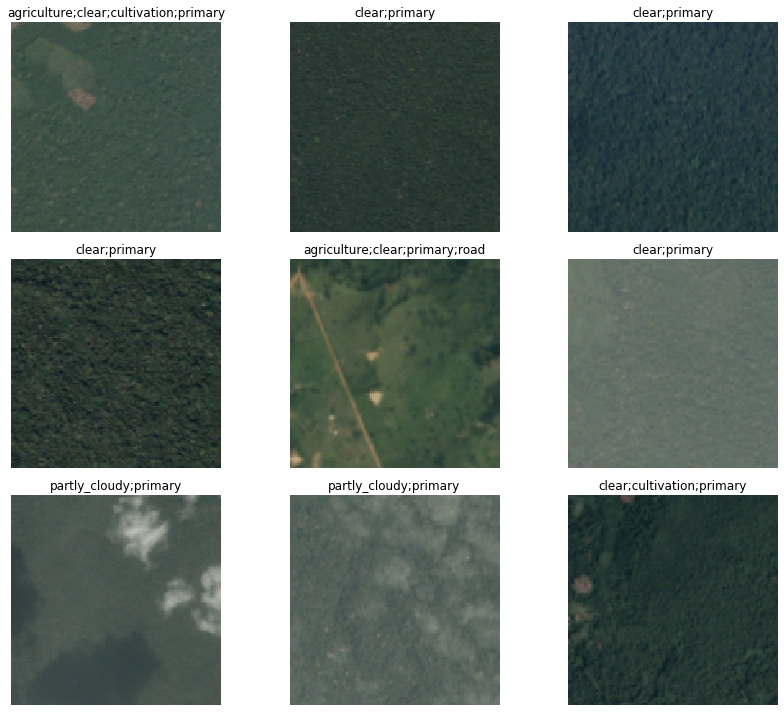

In [9]:
# Displaying our data in batches
data.show_batch(rows=3, figsize=(12, 10))

### Learner Creation

Our learner will be based on the ResNet50 architecture and, keeping in line with the Planet Amazon Kaggle competition, we will use F-beta as our metric. Additionally `accuracy_thresh` will be used to select predictions above a value (0.5 by default) to compare them to the ground truth. 

In [10]:
# Setting Neural Network architecture
arch = models.resnet50

In [11]:
# Setting metrics and creating our learner
acc_thresh = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

learner = cnn_learner(data, arch, metrics=[acc_thresh, f_score])

**Using LR Finder to pick a good learning rate:**

In [28]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02
Min loss divided by 10: 3.63E-02


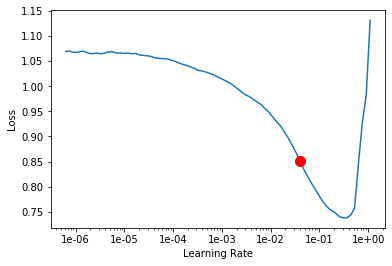

In [31]:
# Plotting the results of the LR Finder
learner.recorder.plot(suggestion=True)

In [32]:
# Setting learning rate 
lr = 0.01

In [34]:
# Fitting the head of our network using the one cycle scheduler
learner.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.139758,0.115305,0.945083,0.900390,01:22
1,0.114183,0.099763,0.949297,0.913870,01:22
2,0.102791,0.094278,0.954657,0.918235,01:23
3,0.096606,0.088428,0.956867,0.924010,01:23
4,0.094014,0.087661,0.956046,0.923270,01:25


In [41]:
# Saving stage-1 of the learner
learner.save('stage-1-resnet50' )

**Un-freezing the network and fine-tuning the whole model**

In [42]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


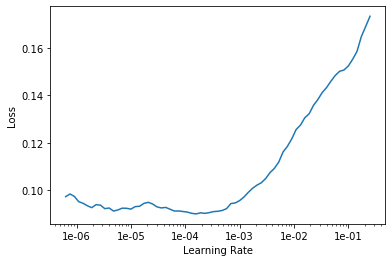

In [43]:
learner.lr_find()
learner.recorder.plot()

In [44]:
learner.fit_one_cycle(6, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095589,0.090530,0.953588,0.921160,01:47
1,0.095969,0.090938,0.956756,0.918596,01:47
2,0.093569,0.086043,0.955948,0.924055,01:48
3,0.088199,0.085091,0.958000,0.927192,01:49
4,0.080763,0.082994,0.957988,0.928123,01:48
5,0.079430,0.082815,0.959599,0.929166,01:48


In [45]:
# Saving the second stage of the model
learner.save('stage-2-resnet50')

**In order to improve our model's ability to generalize to a wider variety of satellite pictures, we will now use a technique called `Progressive Resizing`.**

What this basically means is that our model, which was trained on image sizes of 128 x 128, will now be passed images which have been up sized to 224x224 (also owing to the low GPU memory on hand at the moment) using the DataBlock API. Progressive resizing has been shown to increase model performance in various tests and experiments. 

In [12]:
# loading stage-2 model
gc.collect()
learner.load('stage-2-resnet50')

Learner(data=ImageDataBunch;

Train: LabelList (30360 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary
Path: /home/bilal/.fastai/data/planet;

Valid: LabelList (10119 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /home/bilal/.fastai/data/planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stri

In [13]:
# Creating another DataBunch, this time with images resized to 256x256
# Again, images are normalized to ImageNet stats
data = (source.transform(transforms, size=224)
        .databunch().normalize(imagenet_stats))

In [14]:
# Passing new DataBunch to learner
learner.data = data
# Verifying
data.train_ds[0][0].shape

torch.Size([3, 224, 224])

In [15]:
# Freezing the lower layers of the model once more and determining learning rate
learner.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


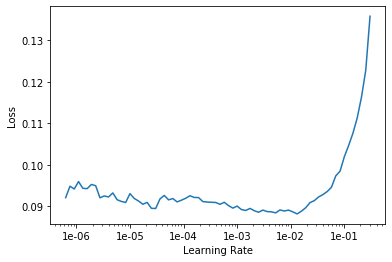

In [16]:
learner.lr_find()
learner.recorder.plot()

In [17]:
lr = 1e-2/2

In [18]:
# Fitting the model using one cycle scheduler
learner.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.083342,0.086249,0.959988,0.926713,04:06
1,0.087314,0.082671,0.958732,0.928176,04:05
2,0.083423,0.083441,0.959930,0.928076,04:15
3,0.081456,0.081887,0.960709,0.929032,04:08
4,0.075941,0.081029,0.958570,0.929885,04:07


In [19]:
# Saving stage-1 of the learner trained on 224x224 images
learner.save('stage-1-224-resnet50')

In [21]:
# Unfreezing and training fine-tuning the whole network
learner.unfreeze()
learner.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.082790,0.083674,0.959418,0.928927,05:23
1,0.085048,0.084891,0.956401,0.925862,05:23
2,0.081798,0.083156,0.957732,0.927656,05:19
3,0.077357,0.081330,0.961197,0.931511,05:22
4,0.072855,0.081086,0.959738,0.930697,05:22


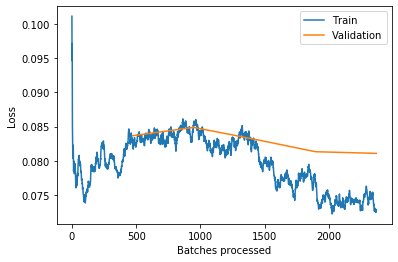

In [22]:
# Plotting the final training and validation losses of our learner
learner.recorder.plot_losses()

In [23]:
# Saving the final model
learner.save('stage-2-224-resnet50')

### Generating Predictions on Test Data

**To be completed after Kaggle test data download**

In [27]:
PATH =  '/home/bilal/.fastai/data/planet'

In [28]:
# Creating test DataBunch
test = ImageList.from_folder(PATH/'test-jpg').add(ImageList.from_folder(PATH/'test-jpg-additional'))
# Size of the test set
len(test)

TypeError: unsupported operand type(s) for /: 'str' and 'str'